# Library and Basic setting

In [1]:
import numpy as np

import torch
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl

# default setting
np.set_printoptions(precision=2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

In [2]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=135,
                    help='size of mini batch')
parser.add_argument('--learning_rate', type=float, default=0.0008, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=.0001, help='decay rate for rmsprop')
parser.add_argument('--lamda_weights', type=float, default=.01, help='lamda weight')
parser.add_argument('--is_normalization', type=bool,
                    default=True, help='whether do data normalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int,
                    help='Input images will be resized to this for data argumentation.')
parser.add_argument('--model_dir', type=str,
                    default='/notebooks/global_localization/lightning/baseline', help='rnn, gru, or lstm')
parser.add_argument('--test_dataset', type=str, default=['/notebooks/michigan_nn_data/2012_02_12',
                                                         '/notebooks/michigan_nn_data/2012_04_29',
                                                         '/notebooks/michigan_nn_data/2012_05_11',
                                                         '/notebooks/michigan_nn_data/2012_06_15',
                                                         '/notebooks/michigan_nn_data/2012_08_04',
                                                         '/notebooks/michigan_nn_data/2012_10_28',
                                                         '/notebooks/michigan_nn_data/2012_11_16',
                                                         '/notebooks/michigan_nn_data/2012_12_01'])
parser.add_argument('--train_dataset', type=str, default=['/notebooks/michigan_nn_data/2012_01_08',
                                                          '/notebooks/michigan_nn_data/2012_01_15',
                                                          '/notebooks/michigan_nn_data/2012_01_22',
                                                          '/notebooks/michigan_nn_data/2012_02_02',
                                                          '/notebooks/michigan_nn_data/2012_02_04',
                                                          '/notebooks/michigan_nn_data/2012_02_05',
                                                          '/notebooks/michigan_nn_data/2012_03_31',
                                                          '/notebooks/michigan_nn_data/2012_09_28'])
parser.add_argument('--norm_tensor', type=str,
                    default=['/notebooks/global_localization/norm_mean_std.pt'])

sys.argv = ['']
args = parser.parse_args()

# Load Dataset

In [3]:
import torchvision.transforms as transforms
import os
import sys
sys.path.append('..')
from torchlib.utils import LocalizationDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import QuantileTransformer

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = LocalizationDataset(dataset_dirs = args.test_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, 
                              get_pair = False, mode='evaluate', sampling_rate=2)

qt_fit = np.load(os.path.join(args.model_dir,'qt_fit.npy'))
qt = QuantileTransformer(n_quantiles = 10000, output_distribution='normal', random_state=0)
qt.fit(qt_fit)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size, \
                        shuffle=False, num_workers=os.cpu_count(), drop_last=False)

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'
100%|██████████| 12683/12683 [00:16<00:00, 779.15it/s]


In [4]:
#from torch.cuda.amp import autocast, GradScaler
import gpytorch
import sys
sys.path.append('..')
from torchlib.GPs import Backbone, NN
from torchlib.cnn_auxiliary import normalize, denormalize_navie


# Gaussian Process Model
class GP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, output_dim=3):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([output_dim])
        )
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=output_dim
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([1]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([1])),
            batch_shape=torch.Size([1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Baseline(pl.LightningModule):

    def __init__(self):
        super().__init__()
        # parameters
        inducing_points = torch.zeros(3, 300, 128)
        self.backbone = Backbone()
        self.nn = NN()
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
            num_tasks=3)
        [norm_mean, norm_std] = torch.load(*args.norm_tensor)
        self.norm_mean = torch.nn.parameter.Parameter(norm_mean,requires_grad=False)
        self.norm_std = torch.nn.parameter.Parameter(norm_std,requires_grad=False) 
        
        # shut down backbone learning
        self._disable_grad(self.backbone)

    def forward(self, x):
        dense_feat = self.backbone(x)
        output, feature_t, feature_r = self.nn(dense_feat)
        _, rot_pred = torch.split(output, [3, 4], dim=1)
        trans_pred = self.gp(feature_t)
        return trans_pred, rot_pred

    def training_step(self, batch, batch_idx):
        x, y = batch.values()
        y = normalize(y, self.norm_mean, self.norm_std)
        train_loss,trans_loss,rot_loss = self.__loss(x, y)
        #self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        tensorboard = self.logger.experiment
        #tensorboard.add_scalar('train_loss',float(train_loss),self.global_step)
        tensorboard.add_scalars('train_loss',
                                {'total_loss':float(train_loss),
                                'trans_loss':float(trans_loss),
                                'rot_loss':float(rot_loss)},
                                self.global_step)
        return train_loss

    def __loss(self, x, y):
        # target
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        # predict
        trans_pred, rot_pred = self.forward(x)

        # trans loss
        mll = gpytorch.mlls.PredictiveLogLikelihood(self.likelihood, self.gp, num_data=num_data)
        trans_loss = -1.*mll(trans_pred, trans_target)
        # rot loss
        rot_loss = 1. - \
            torch.mean(torch.square(
                torch.sum(torch.mul(rot_pred, rot_target), dim=1)))

        total_loss = trans_loss + args.lamda_weights * rot_loss

        return total_loss, trans_loss, rot_loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch.values()
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_pred, rot_pred = self.forward(x)
        
        trans_pred, trans_mean, trans_var = self._eval_gp(trans_pred)
        trans_pred = denormalize_navie(trans_pred, self.norm_mean, self.norm_std)
        trans_mean = denormalize_navie(trans_mean, self.norm_mean, self.norm_std)
        trans_var = trans_var.mul(self.norm_std)
        samples = self._sample(trans_mean, trans_var, 100)
        
        trans_loss = torch.sqrt(torch.sum((trans_pred - trans_target)**2,dim=1)).mean()
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        #return trans_pred, rot_pred, trans_target, rot_target, samples
        
        val_loss = trans_loss
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=False, logger=False)
        tensorboard = self.logger.experiment
        tensorboard.add_scalars('val_loss',
                                {'trans_loss':float(trans_loss),
                                'rot_loss':float(rot_loss)},
                                self.current_epoch*self.trainer.num_val_batches[0]+batch_idx)
        return val_loss
    
    def _eval_gp(self, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = self.likelihood(trans_pred).mean, self.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = torch.distributions.Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_forward(self,x,y):
        x, y = x.to(self.device),y.to(self.device)
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_pred, rot_pred = self.forward(x)
        
        trans_pred, trans_mean, trans_var = self._eval_gp(trans_pred)        
        # transform to raw
        trans_mean = torch.from_numpy(qt.inverse_transform(trans_mean.cpu().numpy())).to(self.device)
        trans_pred = torch.from_numpy(qt.inverse_transform(trans_pred.cpu().numpy()))
        
        samples = self._sample(trans_mean, trans_var, 100)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples
        
    def configure_optimizers(self):
        lr,weight_decay = args.learning_rate,args.weight_decay
        optimizer_args = [
            {'params': self.gp.parameters(), 'lr': lr, 'weight_decay': weight_decay},
            {'params': self.likelihood.parameters(), 'lr': lr,
             'weight_decay': weight_decay},
            {'params': self.nn.global_regressor.parameters(), 'lr': lr * 0.01,
             'weight_decay': weight_decay},
            {'params': self.nn.global_context.parameters(), 'lr': lr * 0.001, 'weight_decay': weight_decay}]
        
        optimizer = torch.optim.Adam(optimizer_args)

        return optimizer
    
    def show_require_grad(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                print (name, param.shape)
                
    def _disable_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def get_progress_bar_dict(self):
        tqdm_dict = super().get_progress_bar_dict()
        if 'v_num' in tqdm_dict:
            del tqdm_dict['v_num']
        return tqdm_dict
    
    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                                  shuffle=True, num_workers=os.cpu_count(),drop_last=True)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                                shuffle=False, num_workers=os.cpu_count(),drop_last=True)
        return val_loader
    
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint


#trainer = pl.Trainer(gpus=1,precision=32)
model = Baseline.load_from_checkpoint(os.path.join(args.model_dir,'pretrained-model-epoch=101-val_loss=0.89.ckpt'))
#trainer.fit(model)

# Initialize

In [5]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

In [6]:
import math

model._disable_grad(model)
model.eval()
model.gp.eval()
model.likelihood.eval()
model.cuda()

for b, data in enumerate(test_loader, 0):
    start = time.time()
    
    x,y = data.values()
    x = x.cuda()
    y = y.cuda()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = model.eval_forward(x,y)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(test_loader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))

135/92070, translation error = 3.257, rotation error = 4.699, time/batch = 3.871
270/92070, translation error = 2.980, rotation error = 3.613, time/batch = 1.208
405/92070, translation error = 11.105, rotation error = 4.162, time/batch = 1.095
540/92070, translation error = 9.291, rotation error = 4.282, time/batch = 1.178
675/92070, translation error = 8.260, rotation error = 3.922, time/batch = 1.147
810/92070, translation error = 7.577, rotation error = 3.874, time/batch = 1.027
945/92070, translation error = 8.924, rotation error = 3.919, time/batch = 1.033
1080/92070, translation error = 8.434, rotation error = 3.954, time/batch = 1.373
1215/92070, translation error = 8.425, rotation error = 3.900, time/batch = 0.908
1350/92070, translation error = 8.215, rotation error = 4.155, time/batch = 0.855
1485/92070, translation error = 7.730, rotation error = 4.220, time/batch = 0.846
1620/92070, translation error = 7.261, rotation error = 4.255, time/batch = 0.908
1755/92070, translatio

13635/92070, translation error = 4.958, rotation error = 4.566, time/batch = 0.922
13770/92070, translation error = 4.964, rotation error = 4.580, time/batch = 1.039
13905/92070, translation error = 4.948, rotation error = 4.567, time/batch = 0.870
14040/92070, translation error = 4.932, rotation error = 4.565, time/batch = 1.054
14175/92070, translation error = 4.913, rotation error = 4.564, time/batch = 0.847
14310/92070, translation error = 4.910, rotation error = 4.588, time/batch = 0.894
14445/92070, translation error = 4.887, rotation error = 4.594, time/batch = 0.947
14580/92070, translation error = 4.861, rotation error = 4.568, time/batch = 0.925
14715/92070, translation error = 4.840, rotation error = 4.559, time/batch = 0.907
14850/92070, translation error = 4.830, rotation error = 4.560, time/batch = 0.913
14985/92070, translation error = 4.811, rotation error = 4.557, time/batch = 0.952
15120/92070, translation error = 4.797, rotation error = 4.563, time/batch = 0.800
1525

27000/92070, translation error = 8.662, rotation error = 5.615, time/batch = 0.923
27135/92070, translation error = 8.627, rotation error = 5.594, time/batch = 0.935
27270/92070, translation error = 8.600, rotation error = 5.578, time/batch = 0.901
27405/92070, translation error = 8.575, rotation error = 5.560, time/batch = 0.913
27540/92070, translation error = 8.546, rotation error = 5.546, time/batch = 0.895
27675/92070, translation error = 8.518, rotation error = 5.528, time/batch = 0.935
27810/92070, translation error = 8.489, rotation error = 5.512, time/batch = 0.944
27945/92070, translation error = 8.462, rotation error = 5.507, time/batch = 0.944
28080/92070, translation error = 8.438, rotation error = 5.493, time/batch = 0.966
28215/92070, translation error = 8.411, rotation error = 5.475, time/batch = 1.005
28350/92070, translation error = 8.405, rotation error = 5.476, time/batch = 0.879
28485/92070, translation error = 8.385, rotation error = 5.479, time/batch = 0.932
2862

40365/92070, translation error = 9.114, rotation error = 5.641, time/batch = 0.974
40500/92070, translation error = 9.091, rotation error = 5.639, time/batch = 1.100
40635/92070, translation error = 9.065, rotation error = 5.633, time/batch = 0.862
40770/92070, translation error = 9.042, rotation error = 5.632, time/batch = 0.928
40905/92070, translation error = 9.018, rotation error = 5.630, time/batch = 0.967
41040/92070, translation error = 9.004, rotation error = 5.642, time/batch = 0.979
41175/92070, translation error = 8.981, rotation error = 5.639, time/batch = 0.903
41310/92070, translation error = 8.960, rotation error = 5.639, time/batch = 1.073
41445/92070, translation error = 8.936, rotation error = 5.625, time/batch = 0.878
41580/92070, translation error = 8.916, rotation error = 5.632, time/batch = 1.082
41715/92070, translation error = 8.891, rotation error = 5.634, time/batch = 0.884
41850/92070, translation error = 8.868, rotation error = 5.632, time/batch = 0.952
4198

53730/92070, translation error = 8.957, rotation error = 5.602, time/batch = 0.987
53865/92070, translation error = 8.938, rotation error = 5.605, time/batch = 1.002
54000/92070, translation error = 8.920, rotation error = 5.601, time/batch = 1.038
54135/92070, translation error = 8.903, rotation error = 5.597, time/batch = 0.869
54270/92070, translation error = 8.986, rotation error = 5.615, time/batch = 1.055
54405/92070, translation error = 8.975, rotation error = 5.626, time/batch = 0.862
54540/92070, translation error = 8.964, rotation error = 5.636, time/batch = 0.944
54675/92070, translation error = 8.945, rotation error = 5.631, time/batch = 0.979
54810/92070, translation error = 8.929, rotation error = 5.633, time/batch = 0.995
54945/92070, translation error = 8.918, rotation error = 5.634, time/batch = 1.101
55080/92070, translation error = 8.900, rotation error = 5.628, time/batch = 0.864
55215/92070, translation error = 8.884, rotation error = 5.626, time/batch = 0.939
5535

67095/92070, translation error = 10.161, rotation error = 6.140, time/batch = 1.084
67230/92070, translation error = 10.161, rotation error = 6.152, time/batch = 0.904
67365/92070, translation error = 10.150, rotation error = 6.170, time/batch = 0.996
67500/92070, translation error = 10.142, rotation error = 6.184, time/batch = 0.994
67635/92070, translation error = 10.126, rotation error = 6.181, time/batch = 0.953
67770/92070, translation error = 10.110, rotation error = 6.173, time/batch = 0.993
67905/92070, translation error = 10.095, rotation error = 6.164, time/batch = 1.128
68040/92070, translation error = 10.078, rotation error = 6.157, time/batch = 0.910
68175/92070, translation error = 10.063, rotation error = 6.151, time/batch = 0.941
68310/92070, translation error = 10.049, rotation error = 6.150, time/batch = 0.927
68445/92070, translation error = 10.035, rotation error = 6.147, time/batch = 0.976
68580/92070, translation error = 10.022, rotation error = 6.146, time/batch 

80460/92070, translation error = 11.086, rotation error = 6.572, time/batch = 0.882
80595/92070, translation error = 11.224, rotation error = 6.593, time/batch = 0.910
80730/92070, translation error = 11.250, rotation error = 6.611, time/batch = 0.974
80865/92070, translation error = 11.254, rotation error = 6.607, time/batch = 0.925
81000/92070, translation error = 11.247, rotation error = 6.606, time/batch = 0.953
81135/92070, translation error = 11.253, rotation error = 6.606, time/batch = 0.980
81270/92070, translation error = 11.257, rotation error = 6.636, time/batch = 0.979
81405/92070, translation error = 11.306, rotation error = 6.650, time/batch = 0.965
81540/92070, translation error = 11.296, rotation error = 6.662, time/batch = 1.012
81675/92070, translation error = 11.286, rotation error = 6.660, time/batch = 0.864
81810/92070, translation error = 11.273, rotation error = 6.657, time/batch = 0.947
81945/92070, translation error = 11.266, rotation error = 6.661, time/batch 

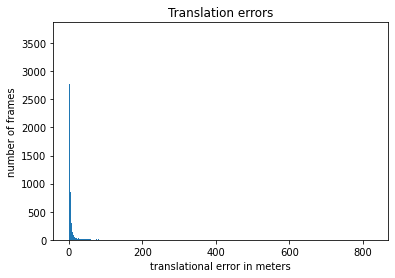

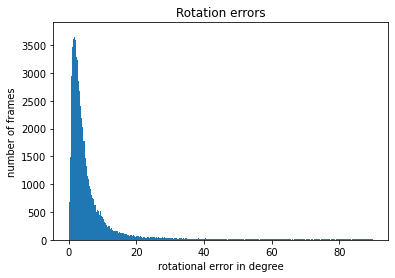

median translation error = 2.627
median rotation error = 3.494
mean translation error = 11.215
mean rotation error = 6.877


In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
#plt.savefig('terror.png', bbox_inches='tight')
plt.show()

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
#plt.savefig('rerror.png', bbox_inches='tight')
plt.show()

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

In [8]:
def evaluate(trans_errors,rot_errors):
    t = test_dataset.last_indexes
    trans_errors_month = list()
    trans_errors_month.append(trans_errors[:t[0]])
    trans_errors_month.append(trans_errors[t[0]:t[1]])
    trans_errors_month.append(trans_errors[t[1]:t[2]])
    trans_errors_month.append(trans_errors[t[2]:t[3]])
    trans_errors_month.append(trans_errors[t[3]:t[4]])
    trans_errors_month.append(trans_errors[t[4]:t[5]])
    trans_errors_month.append(trans_errors[t[5]:t[6]])
    trans_errors_month.append(trans_errors[t[6]:])

    rot_errors_month = list()
    rot_errors_month.append(rot_errors[:t[0]])
    rot_errors_month.append(rot_errors[t[0]:t[1]])
    rot_errors_month.append(rot_errors[t[1]:t[2]])
    rot_errors_month.append(rot_errors[t[2]:t[3]])
    rot_errors_month.append(rot_errors[t[3]:t[4]])
    rot_errors_month.append(rot_errors[t[4]:t[5]])
    rot_errors_month.append(rot_errors[t[5]:t[6]])
    rot_errors_month.append(rot_errors[t[6]:])
    
    print('================== median translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("median translation error = {:.3f}".format(np.median(trans_errors_i)))
        
    print('================== median rotation error ==================')
    for rot_errors_i in rot_errors_month:
        print("median rotation error = {:.3f}".format(np.median(rot_errors_i)))
    
    print('================== mean translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("mean translation error = {:.3f}".format(np.mean(trans_errors_i)))
        
    print('================== mean rotation error ==================')  
    for rot_errors_i in rot_errors_month:
        print("mean rotation error = {:.3f}".format(np.mean(rot_errors_i)))
        
evaluate(trans_errors,rot_errors)

================== median translation error ==================
median translation error = 2.130
median translation error = 2.069
median translation error = 2.455
median translation error = 2.336
median translation error = 2.627
median translation error = 2.654
median translation error = 4.100
median translation error = 3.882
================== median rotation error ==================
median rotation error = 3.200
median rotation error = 3.207
median rotation error = 3.129
median rotation error = 3.251
median rotation error = 3.429
median rotation error = 3.465
median rotation error = 4.599
median rotation error = 4.762
================== mean translation error ==================
mean translation error = 4.909
mean translation error = 4.224
mean translation error = 12.697
mean translation error = 12.605
mean translation error = 10.478
mean translation error = 12.075
mean translation error = 19.276
mean translation error = 14.902
================== mean rotation error ==================
